In [99]:
import numpy as np
import pandas as pd
from sklearn.semi_supervised import LabelPropagation, LabelSpreading
from sklearn.svm import SVC, libsvm
from sklearn.ensemble import RandomForestClassifier
import matplotlib.pyplot as plt
import matplotlib.animation as animation
from glob import glob
import os
import time

## 9つの視点から撮影したデータをロード

In [2]:
vp_type = "*"  # Viewpoint type

pict_dir = "../_ignored/data/push-ups_2017-12-05/{}/pict/2-1.COCO-pose/".format(vp_type)
for f in glob(pict_dir):
    print(f)

print()    

movie_dir = "../_ignored/data/push-ups_2017-12-05/{}/movie/2-1.COCO-pose/".format(vp_type)
for f in glob(movie_dir):
    print(f)
    
print()
misc_pict_dir = ["../_ignored/data/pict_push-ups-from-side/2-1.COCO-pose/0_up.csv", \
                 "../_ignored/data/pict_push-ups-from-side/2-1.COCO-pose/1_down.csv"]
misc_movie_dir = "../_ignored/data/movie_push-ups-from-side/2-1.COCO-pose_mod/"

data_files = glob(pict_dir + "*.csv") + glob(movie_dir + "*.csv")
misc_data_files = misc_pict_dir + glob(misc_movie_dir + "*.csv")
[print(f) for f in misc_data_files]

../_ignored/data/push-ups_2017-12-05/lower_side/pict/2-1.COCO-pose/
../_ignored/data/push-ups_2017-12-05/lower_front/pict/2-1.COCO-pose/
../_ignored/data/push-ups_2017-12-05/middle_naname/pict/2-1.COCO-pose/
../_ignored/data/push-ups_2017-12-05/upper_naname/pict/2-1.COCO-pose/
../_ignored/data/push-ups_2017-12-05/middle_side/pict/2-1.COCO-pose/
../_ignored/data/push-ups_2017-12-05/upper_front/pict/2-1.COCO-pose/
../_ignored/data/push-ups_2017-12-05/middle_front/pict/2-1.COCO-pose/
../_ignored/data/push-ups_2017-12-05/upper_side/pict/2-1.COCO-pose/
../_ignored/data/push-ups_2017-12-05/lower_naname/pict/2-1.COCO-pose/

../_ignored/data/push-ups_2017-12-05/lower_side/movie/2-1.COCO-pose/
../_ignored/data/push-ups_2017-12-05/lower_front/movie/2-1.COCO-pose/
../_ignored/data/push-ups_2017-12-05/middle_naname/movie/2-1.COCO-pose/
../_ignored/data/push-ups_2017-12-05/upper_naname/movie/2-1.COCO-pose/
../_ignored/data/push-ups_2017-12-05/middle_side/movie/2-1.COCO-pose/
../_ignored/data/push-u

[None, None, None, None, None, None, None, None]

In [3]:
def loadCSV(file):
    df = pd.read_csv(file, header=None, dtype=str)
    return df.values

def fillNan(file):
    df = pd.read_csv(file, header=None, dtype=str)
    idx = np.arange(55)
    idx[0], idx[-1] = 54, 0
    df[df.isnull().any(axis=1)] = df[df.isnull().any(axis=1)].iloc[:, idx]
    df = df.replace(np.nan, "0")
    return df.values

def loadAllData(csv_list, vs, hs, stats = ["_up", "_down", "movie"]):
    out = [{} for _ in range(2*len(stats))]
    
    for v in vs:
        for h in hs:
            pos = v + "_" + h
            filtered_csv_list = list(filter(lambda x: pos in x, csv_list))
            # print(filtered_csv_list)
            for i, s in enumerate(stats):
                arrays = [fillNan(f) for f in filtered_csv_list if s in f]
                if len(arrays) > 0:
                    tmp = np.vstack(arrays)
                    out[2*i][pos] = tmp[:, :-1].astype(float)
                    out[2*i + 1][pos] = tmp[:, -1].astype(str)
                else:
                    out[2*i][pos] = None
                    out[2*i + 1][pos] = None
#                 out[i][pos] = tmp
    return out
                
def loadMiscData(csv_list):
    stats = ["_up", "_down", "movie"]
    out = []
    for s in stats:
        arrays = [fillNan(f) for f in csv_list if s in f]
        if len(arrays) > 0:
            tmp = np.vstack(arrays)
            out.append(tmp[:, :-1].astype(float))
            out.append(tmp[:, -1].astype(str))
    return out
    
# def loadData(stat, pict, movie):
#     def getIntgData(which, dirs):
#         _dir = filter(lambda x: which in x, dirs)
#         out = np.vstack([loadCSV(d) for s in stat for d in _dir if s in d])
#         return out
#     up_data = getIntgData("_up", pict)
#     down_data = getIntgData("_down", pict)
#     movie_data = getIntgData("movie", movie)
#     return up_data, down_data, movie_data

In [4]:
v_stat = ["lower", "middle", "upper"]
h_stat = ["side", "naname", "front"]

In [5]:
up_data, up_names, down_data, down_names, movie_data, movie_names = loadAllData(data_files, v_stat, h_stat)
up_data1, up_names1, down_data1, down_names1, movie_data1, movie_names1 = loadMiscData(data_files)

for pos in ["up", "down", "movie"]:
    for typ in ["data", "names"]:
        exec("{0}_{1}['misc'] = {0}_{1}1".format(pos, typ))

In [6]:
up_data.keys()

dict_keys(['lower_side', 'lower_naname', 'lower_front', 'middle_side', 'middle_naname', 'middle_front', 'upper_side', 'upper_naname', 'upper_front', 'misc'])

In [7]:
def chooseRL(data):
    '''
    data: data_num x 54
    '''
    if data is None:
        return np.zeros((1, 6))
        
    right = np.arange(2, 5)
    left = np.arange(5, 8)
    _data = data.reshape(-1, 18, 3)
    conf_r = _data[:, right, 2]  # n_data x 3
    conf_l = _data[:, left, 2]   # n_data x 3
    
    def isZeroInRow(tmp):
        # tmp: n_data x n_joint
        return np.any(tmp == 0, axis=1)

    right_bool, left_bool = np.zeros(18, dtype=bool), np.zeros(18, dtype=bool)
    right_bool[right] = True
    left_bool[left] = True
    rl_bool = (left_bool, right_bool)
    
    conf_0 = np.logical_xor(isZeroInRow(conf_r), isZeroInRow(conf_l))    # inclusion of zero for r&l matches
    conf_nonzero = isZeroInRow(conf_r) > isZeroInRow(conf_l)
    conf_val = (np.mean(conf_r, axis=1) > np.mean(conf_l, axis=1))  # mean conf for r is larger than l
    mask = np.zeros(_data.shape[:2], dtype=bool)
    # 左右どちらもconf=0の関節がある場合、どうせそのデータは削除されるので適当に選ぶ
    # 左右どちらもconf=0の関節がない場合、平均confが大きい方を選ぶ
    # これらはまとめて処理できる
    for i in range(data.shape[0]):
        if conf_0[i]:
            mask[i] = rl_bool[conf_val[i]]
        else:
            mask[i] = rl_bool[conf_nonzero[i]]

    pos = _data[mask, :2]
    out = pos.reshape(-1, 6)
    return out

def extractJointPos(data, index_list):
    return np.dstack([data[:, index_list*3], data[:, index_list*3+1]]).reshape(-1, 2*len(index_list))

def extractJointConf(data, index_list):
    return data[:, index_list*3+2]

def normalizePos(pos, all_data):
    '''
    Assuming...
    pos: n_data x (2*n_selected_joint); x, y, ...
    all_data: n_data x (3*n_all_joint); x, y, conf, ...
    '''
    if all_data is None:
        return np.zeros_like(pos)
    N, d = pos.shape
    N, D = all_data.shape
    pos = pos.reshape(N, d//2, 2)
    all_data = all_data.reshape(N, D//3, 3)[:, :, 0:2]
    xy_max = np.max(all_data, axis=1)[:, np.newaxis]
    xy_min = np.min(all_data, axis=1)[:, np.newaxis]
    out = (pos - xy_min)/(xy_max - xy_min)
    return out.reshape(N, d)

# def normalizePos(pos, all_data):
#     '''
#     Assuming...
#     pos: n_data x (2*n_selected_joint); x, y, ...
#     all_data: n_data x (3*n_all_joint); x, y, conf, ...
#     '''
#     rows, cols = pos.shape
#     all_rows, all_cols = all_data.shape
#     if all_cols % 3 != 0:
#         print("all_data needs 3*n cols")
#         return
#     x = all_data[:, range(0, 54, 3)]
#     y = all_data[:, range(1, 54, 3)]
#     conf = all_data[:, range(2, 54, 3)]
    
#     x_max = np.max(x, axis=1, keepdims=True)
#     x[conf < 0.05] = np.inf
#     x_min = np.min(x, axis=1, keepdims=True)
    
#     y_max = np.max(y, axis=1, keepdims=True)
#     y[conf < 0.05] = np.inf
#     y_min = np.min(y, axis=1, keepdims=True)
    
#     pos_max = np.tile(np.reshape(np.dstack([x_max, y_max]), (-1, 2)), (1, cols//2))
#     pos_min = np.tile(np.reshape(np.dstack([x_min, y_min]), (-1, 2)), (1, cols//2))
    
#     # return pos / (pos_max - pos_min)
#     return (pos - pos_min)/(pos_max - pos_min)

def getMaskForLowConf(pos):
    N, d = pos.shape
    mask = np.ones(N, dtype=bool)
    mask[np.any(pos == 0., axis=1)] = False
    return mask

def deleteLowConf(pos, data):
    '''
    data: data_num x (2*joint_num)
    '''
    mask = getMaskForLowConf(pos)
    return pos[mask], data[mask], mask

def makeFeature(pos):
    n, d = pos.shape
    d //= 2
    _pos = pos.reshape(n, d, 2)
    # カーネル行列を作る時に使うテクニックのテンソル版
    a = np.repeat(np.sum(_pos**2, axis=2)[:, :, np.newaxis], d, axis=2)
    b = np.transpose(a, (0, 2, 1))
    c = np.einsum("ijk,ilk->ijl", _pos, _pos)
    out = a - 2*c + b
    i1, i2 = np.triu_indices(d, k=1)
    out = out[np.repeat(np.arange(n), [d*(d-1)//2]), np.tile(i1, n), np.tile(i2, n)].reshape(n, d*(d-1)//2)
    return out

def mapdict(dic, func):
    if type(dic) == dict:
        return {k:func(v) for (k, v) in dic.items()}
    elif type(dic) in [list, tuple]:
        keys = dic[0].keys()
        return {k:func(*list(map(lambda x: x.get(k), dic))) for k in keys}

In [8]:
up_pos = mapdict(up_data, chooseRL)
up_mask = mapdict(up_pos, getMaskForLowConf)
down_pos = mapdict(down_data, chooseRL)
down_mask = mapdict(down_pos, getMaskForLowConf)
movie_pos = mapdict(movie_data, chooseRL)
movie_mask = mapdict(movie_pos, getMaskForLowConf)

In [9]:
nm_up_pos = mapdict([up_pos, up_data], normalizePos)
nm_down_pos = mapdict([down_pos, down_data], normalizePos)
nm_movie_pos = mapdict([movie_pos, movie_data], normalizePos)

/Users/kentaro_abe/.pyenv/versions/anaconda3-4.4.0/lib/python3.6/site-packages/ipykernel_launcher.py:60: RuntimeWarning: invalid value encountered in true_divide


In [10]:
# 距離を特徴量にする
nm_up_pos = mapdict(nm_up_pos, makeFeature)
nm_down_pos = mapdict(nm_down_pos, makeFeature)
nm_movie_pos = mapdict(nm_movie_pos, makeFeature)

In [11]:
train_key = ["{}_{}".format(a, b) for a in ["upper", "middle", "lower"] for b in ["side", "naname", "front"]] + ["misc"]

In [120]:
def makeTrainData():
    train_key = ["{}_{}".format(a, b) for a in ["upper", "middle", "lower"] for b in ["side", "naname", "front"]] + ["misc"]
    train_nm_up_pos = np.vstack([nm_up_pos[k] for k in train_key])
    train_nm_down_pos = np.vstack([nm_down_pos[k] for k in train_key])
    train_nm_movie_pos = np.vstack([nm_movie_pos[k] for k in train_key])
    train_nm_up_mask = np.hstack([up_mask[k] for k in train_key])
    train_nm_down_mask = np.hstack([down_mask[k] for k in train_key])
    train_nm_movie_mask = np.hstack([movie_mask[k] for k in train_key])
    
    train_data = np.vstack([train_nm_up_pos, train_nm_down_pos])#, train_nm_movie_pos])
    train_mask = np.hstack([train_nm_up_mask, train_nm_down_mask])#, train_nm_movie_mask])
    
    labels = np.hstack([
        1 * np.ones(train_nm_up_pos.shape[0], dtype=int),
        0 * np.ones(train_nm_down_pos.shape[0], dtype=int)#,
        #-1* np.ones(train_nm_movie_pos.shape[0], dtype=int)
    ])
    
    return train_data, train_mask, labels

def makeTestData(a, b):
    test_key = ["{}_{}".format(a, b)]
#   test_key = ["misc"]
    
    test_nm_up_pos = np.vstack([nm_up_pos[k] for k in test_key])
    test_nm_down_pos = np.vstack([nm_down_pos[k] for k in test_key])
    test_nm_movie_pos = np.vstack([nm_movie_pos[k] for k in test_key])

    
    test_nm_up_mask = np.hstack([up_mask[k] for k in test_key])
    test_nm_down_mask = np.hstack([down_mask[k] for k in test_key])
    test_nm_movie_mask = np.hstack([movie_mask[k] for k in test_key])

    
    test_data = test_nm_movie_pos[:len(test_nm_movie_pos)]
   
    test_mask = test_nm_movie_mask[:len(test_nm_movie_pos)]# np.hstack([test_nm_up_mask, test_nm_down_mask, test_nm_movie_mask])
    
    return test_data, test_mask

In [121]:
def train(train_data, train_mask, labels):
    clf = SVC()
    clf.fit(train_data[train_mask], labels[train_mask])
    return clf

def predict(clf, test_data):
    pred_label = clf.predict(test_data)
#         pred_proba = clf.predict_proba(test_data[test_mask])

    return pred_label

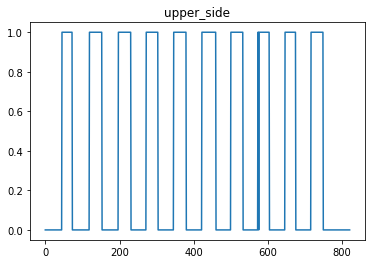

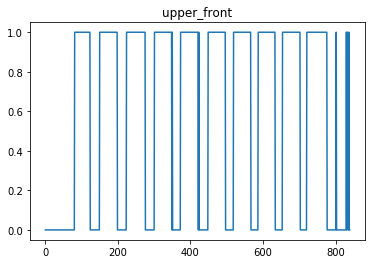

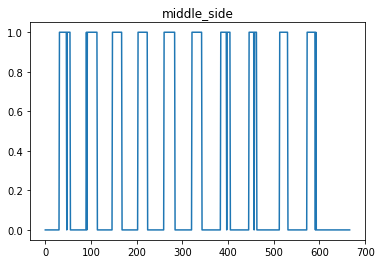

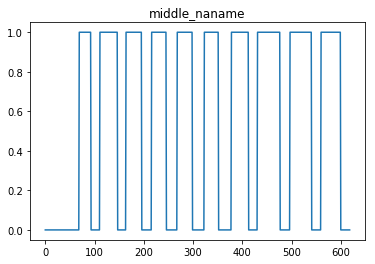

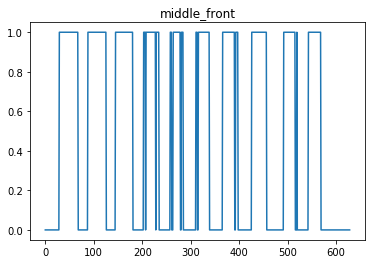

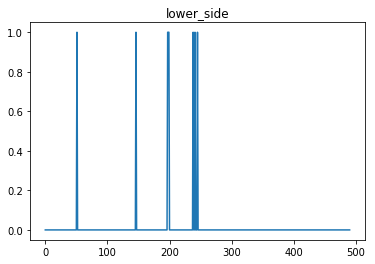

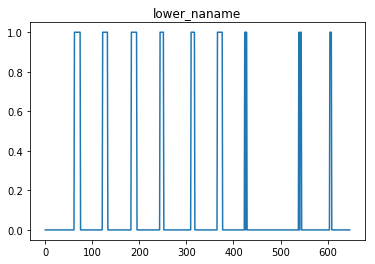

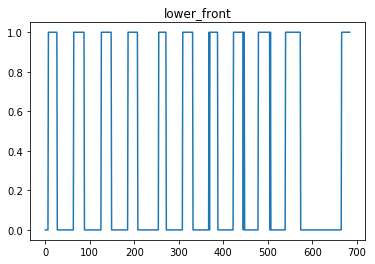

In [122]:
for i, a in enumerate(["upper", "middle", "lower"]):
    for j, b in enumerate(["side", "naname", "front"]):
        if a == "upper" and b == "naname":
            continue
        
        clf = train(*makeTrainData())
        test_data, test_mask = makeTestData(a, b)
        pred_label = predict(clf, test_data[test_mask])
        
        fig = plt.figure(3*i + j)
        plt.title("{}_{}".format(a, b))
        plt.plot(pred_label)
#         plt.plot(pred_proba[:, 1])
        plt.show()
        

In [55]:
filename = "/Users/kentaro_abe/Graduate/ClonedGitReps/libsvm/user_programs/binTest/pred_proba.txt"
output = []
with open(filename, "r") as f:
    f.readline()
    for line in f.readlines():
        output.append(int(line.split(" ")[0]))
output = np.array(output)

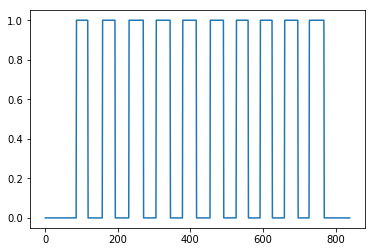

In [57]:
plt.plot(output)
plt.show()

# libsvmのテスト用にデータ出力

In [51]:
train = train_data[train_mask]
label = labels[train_mask]
test = test_data[test_mask]

In [47]:
def makeLibsvmInput(filename, data, label=None):
    '''
    data: (n_samples, dimension)
    label: (n_samples,)
    '''
    if label is None:
        label = -np.ones(data.shape[0])
    else:
        assert data.shape[0] == label.shape[0]
    label = label.astype(int)
    with open(filename, "w") as f:
        for x, l in zip(data, label):
            s = "{} ".format(l)
            for (i, v) in enumerate(x):
                s += "{}:{} ".format(i+1, v)
            print(s, file=f)

In [52]:
makeLibsvmInput("train.txt", train, label)

In [53]:
makeLibsvmInput("pred_test.txt", test, pred_label)

In [37]:
%%bash
cat test.txt

-1 1:0.09273324029389607 2:0.340777668743657 3:0.0779793203592467 
-1 1:0.09671300025474955 2:0.33710656583983156 3:0.07269583528270918 
-1 1:0.09281854691571001 2:0.3371224813951015 3:0.0761556978575828 
-1 1:0.10070393391459154 2:0.33719730526804115 3:0.06935907149886322 
-1 1:0.10470326949450859 2:0.34079497133801673 3:0.06770476496433875 
-1 1:0.1027435316173071 2:0.34089833846132844 3:0.06934199741435831 
-1 1:0.09672089614558232 2:0.3408302464573294 3:0.07442357908307695 
-1 1:0.09924864147940793 2:0.3467082987339386 3:0.07495653041900496 
-1 1:0.0934151357110099 2:0.3393344119141206 3:0.07666547207413998 
-1 1:0.09537895021088405 2:0.33928149040718847 3:0.07488099552556604 
-1 1:0.09993752100903885 2:0.34517856151172155 3:0.07365254700952129 
-1 1:0.10197205740243276 2:0.3452266019872037 3:0.07194692074100462 
-1 1:0.09798867781820642 2:0.33781610026284936 3:0.07192849195392292 
-1 1:0.09403853014388963 2:0.33411441566531175 3:0.07364130957686532 
-1 1:0.0994111122740784 2:0.339

## libsvmとSVCの比較

upper_side
Inconsistency  0.0


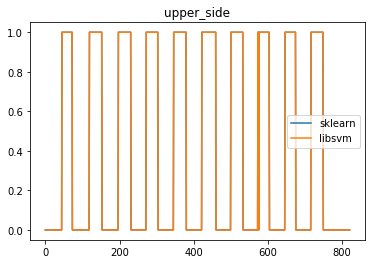

upper_front
Inconsistency  0.0


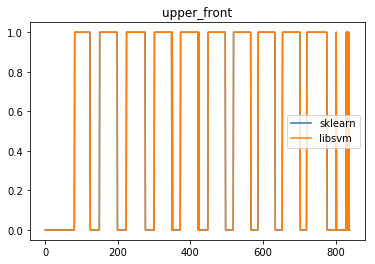

middle_side
Inconsistency  0.0


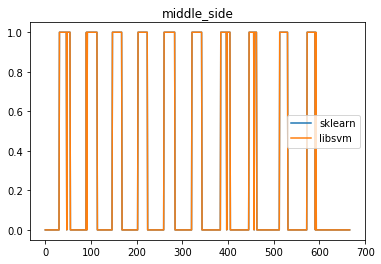

middle_naname
Inconsistency  0.0


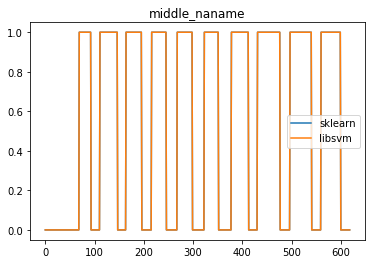

middle_front
Inconsistency  0.0


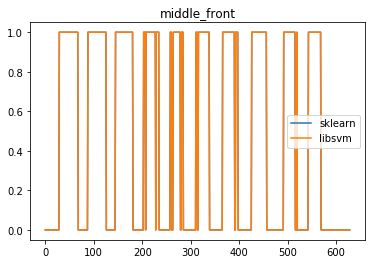

lower_side
Inconsistency  0.0


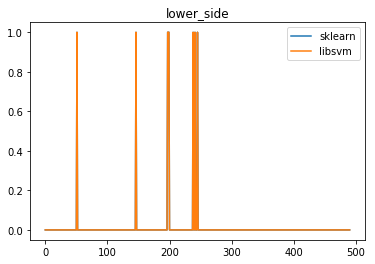

lower_naname
Inconsistency  0.0


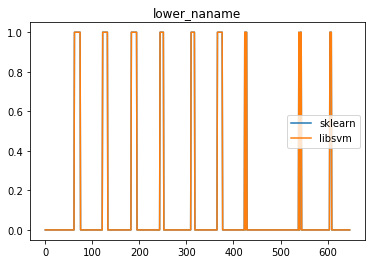

lower_front
Inconsistency  0.0


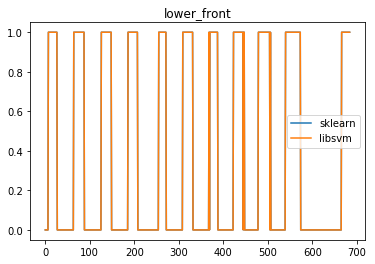

In [116]:
for i, a in enumerate(["upper", "middle", "lower"]):
    for j, b in enumerate(["side", "naname", "front"]):
        if a == "upper" and b == "naname":
            continue
        pos = "{}_{}".format(a, b)
        train_key = ["{}_{}".format(a, b) for a in ["upper", "middle", "lower"] for b in ["side", "naname", "front"]] + ["misc"]
        test_key = [pos]
#         test_key = ["misc"]
        
        if False:
            for tk in test_key:
                del train_key[train_key.index(tk)]
        
        train_nm_up_pos = np.vstack([nm_up_pos[k] for k in train_key])
        train_nm_down_pos = np.vstack([nm_down_pos[k] for k in train_key])
        train_nm_movie_pos = np.vstack([nm_movie_pos[k] for k in train_key])
        test_nm_up_pos = np.vstack([nm_up_pos[k] for k in test_key])
        test_nm_down_pos = np.vstack([nm_down_pos[k] for k in test_key])
        test_nm_movie_pos = np.vstack([nm_movie_pos[k] for k in test_key])
        
        train_nm_up_mask = np.hstack([up_mask[k] for k in train_key])
        train_nm_down_mask = np.hstack([down_mask[k] for k in train_key])
        train_nm_movie_mask = np.hstack([movie_mask[k] for k in train_key])
        test_nm_up_mask = np.hstack([up_mask[k] for k in test_key])
        test_nm_down_mask = np.hstack([down_mask[k] for k in test_key])
        test_nm_movie_mask = np.hstack([movie_mask[k] for k in test_key])
        
        train_data = np.vstack([train_nm_up_pos, train_nm_down_pos])#, train_nm_movie_pos])
        test_data = test_nm_movie_pos[:len(test_nm_movie_pos)]
        train_mask = np.hstack([train_nm_up_mask, train_nm_down_mask])#, train_nm_movie_mask])
        test_mask = test_nm_movie_mask[:len(test_nm_movie_pos)]# np.hstack([test_nm_up_mask, test_nm_down_mask, test_nm_movie_mask])
        
        labels = np.hstack([
            1 * np.ones(train_nm_up_pos.shape[0], dtype=int),
            0 * np.ones(train_nm_down_pos.shape[0], dtype=int)#,
            #-1* np.ones(train_nm_movie_pos.shape[0], dtype=int)
        ])
#         print(labels.shape)
        
        train = train_data[train_mask]
        label = labels[train_mask]
        test = test_data[test_mask]
        # ------------------------------------
        probability = False
        plot_proba = False
        # ------------------------------------
        p_flag = int(probability)
        clf = SVC(probability=probability)
        clf.fit(train, label)
        
        if probability:
            pred_proba = clf.predict_proba(test)
            pred_label = np.argmax(pred_proba, axis=1)
        else:
            pred_label = clf.predict(test)

        train_file = "./libsvm/train_{}.txt".format(pos)
        test_file = "./libsvm/test_{}.txt".format(pos)
        output_file = "./libsvm/pred_{}.txt".format(pos)
        makeLibsvmInput(train_file, train, label)
        makeLibsvmInput(test_file, test, pred_label)
    
        # -b 0: probability=False
        cmd1 = "./libsvm/svm-train -b {0} {1} {1}.model".format(p_flag, train_file)
#         print(cmd1)
        os.system(cmd1)
        
        time.sleep(.1)
        
        cmd2 = "./libsvm/svm-predict -b {0} {1} {2}.model {3}".format(p_flag, test_file, train_file, output_file)
#         print(cmd2)
        os.system(cmd2)
        
        with open(output_file, "r") as f:
            if probability:
                f.readline()
                lib_pred_label = []
                lib_pred_proba = []
                for line in f.readlines():
                    ll = line.split(" ")
                    lib_pred_label.append(int(ll[0]))
                    lib_pred_proba.append(list(map(float, ll[1:])))
                lib_pred_label = np.array(lib_pred_label)
                lib_pred_proba = np.array(lib_pred_proba)
            else:
                lib_pred_label = np.array(f.read().strip().split("\n")).astype(int)
        print(pos)
        print("Inconsistency ", np.sum(pred_label != lib_pred_label)/pred_label.shape[0])
        
        fig = plt.figure(3*i + j)
        plt.title(test_key[0])
        if probability and plot_proba:
                plt.plot(pred_proba[:, 1], label="sklearn")
                plt.plot(lib_pred_proba[:, 0], label="libsvm")
        else:
            plt.plot(pred_label, label="sklearn")
            plt.plot(lib_pred_label, label="libsvm")
            
        plt.legend(loc="best")
#         plt.plot(pred_proba[:, 1])
        plt.show()

In [111]:
p_flag

1

# libsvm用のデータセット作成

In [129]:
train_data, train_mask, labels = makeTrainData()
train = train_data
makeLibsvmInput("train2.txt", train, label)

In [132]:
%%bash
./libsvm/svm-train train2.txt 

*
optimization finished, #iter = 90
nu = 0.900124
obj = -139.805995, rho = -0.311196
nSV = 170, nBSV = 168
Total nSV = 170


In [133]:
%%bash
ls

0_OnlyRIghtArm.ipynb
1_NormalizationAndFeature.ipynb
2_TestRatio.ipynb
3_1_ModifyCSV.ipynb
3_VariousPeople.ipynb
4_1_VariousViewpointForPushup.ipynb
5_1_MakeFileForLibSVM.ipynb
5_MethodCheck.ipynb
6_Semi-Supervised_SelfImpl.ipynb
GPU_Setup.md
README.md
Test.ipynb
cpp
libsvm
output.txt
output2.txt
output_feature.txt
supervised.mp4
supervised2.mp4
train2.txt
train2.txt.model
